In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.options.mode.chained_assignment = None  # default='warn'

# Exploración de Datos

In [82]:
dfToUse = "consumo"

def returnQuantRows(dfToUse):
    if (dfToUse == 'consumo'):
        return 269 
    return 257

toUse = returnQuantRows(dfToUse)

In [83]:
df = pd.read_excel(dfToUse+'.xlsx', engine='openpyxl')
df = df[['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel']]

In [84]:
df = df[:toUse]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [85]:
df

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2000-01-01,308157,202645,634667
1,2000-02-01,307766,205531,642381
2,2000-03-01,331910,229500,699807
3,2000-04-01,315648,210680,586804
4,2000-05-01,319668,208164,656948
...,...,...,...,...
264,2022-01-01,622475,684004,1.29426e+06
265,2022-02-01,592075,660944,1.27576e+06
266,2022-03-01,599582,703128,1.3452e+06
267,2022-04-01,566128,807440,1.29416e+06


In [86]:
quant_vars = ['Gasolina superior', 'Gasolina regular', 'Diesel']
df[quant_vars].astype(float).describe()

,Gasolina superior,Gasolina regular,Diesel
count,269.000000,269.000000,2.690000e+02
mean,451431.636263,348337.277960,8.390665e+05
std,102271.841049,172663.330234,1.965830e+05
min,300242.781667,160741.900000,5.076627e+05
25%,380800.430000,212696.380000,6.881041e+05
50%,411088.530000,268917.790000,7.936940e+05
75%,545210.000000,476277.640000,9.687487e+05
max,768102.830000,821882.150000,1.427888e+06


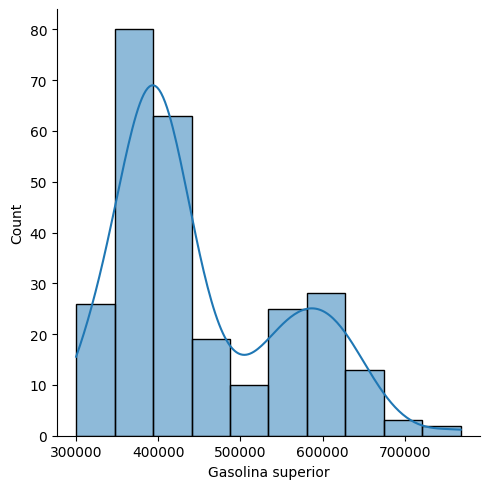

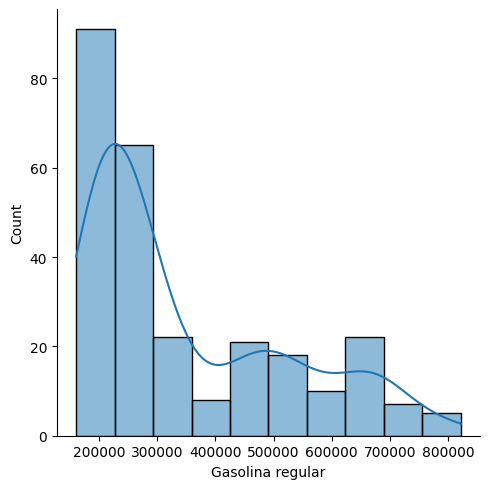

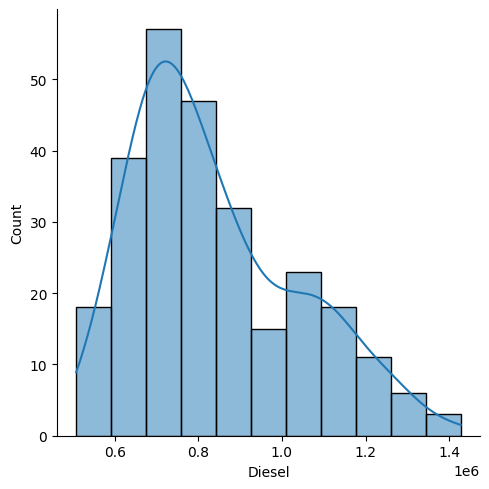

In [87]:
for var in quant_vars:
    data = df[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)
    # print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')


# Por año

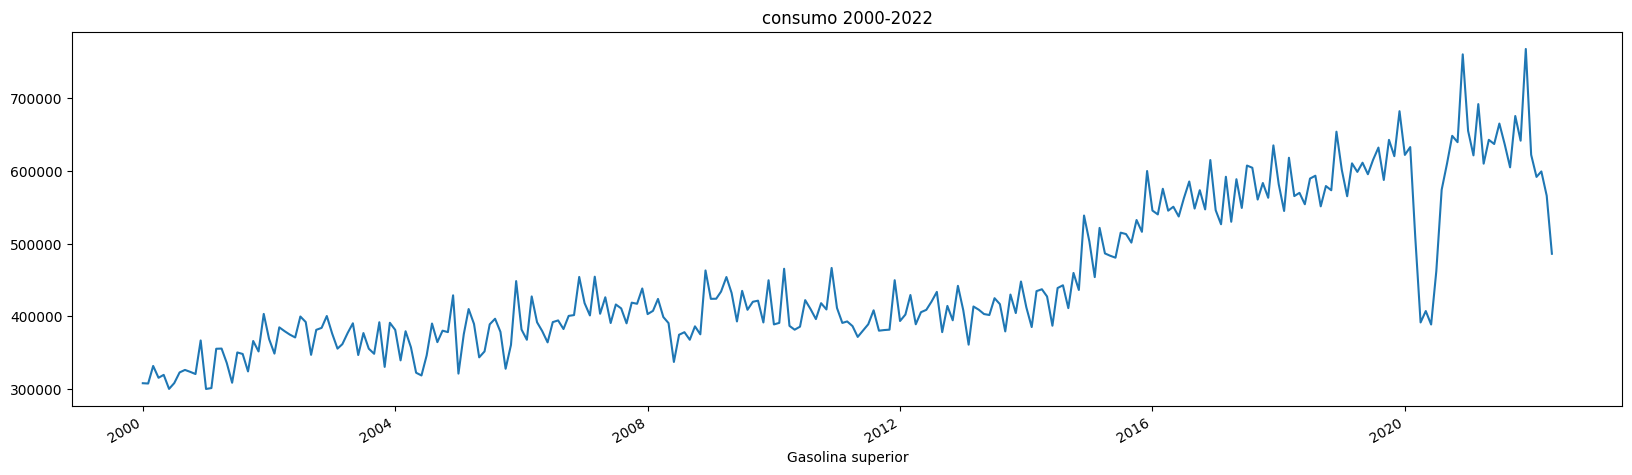

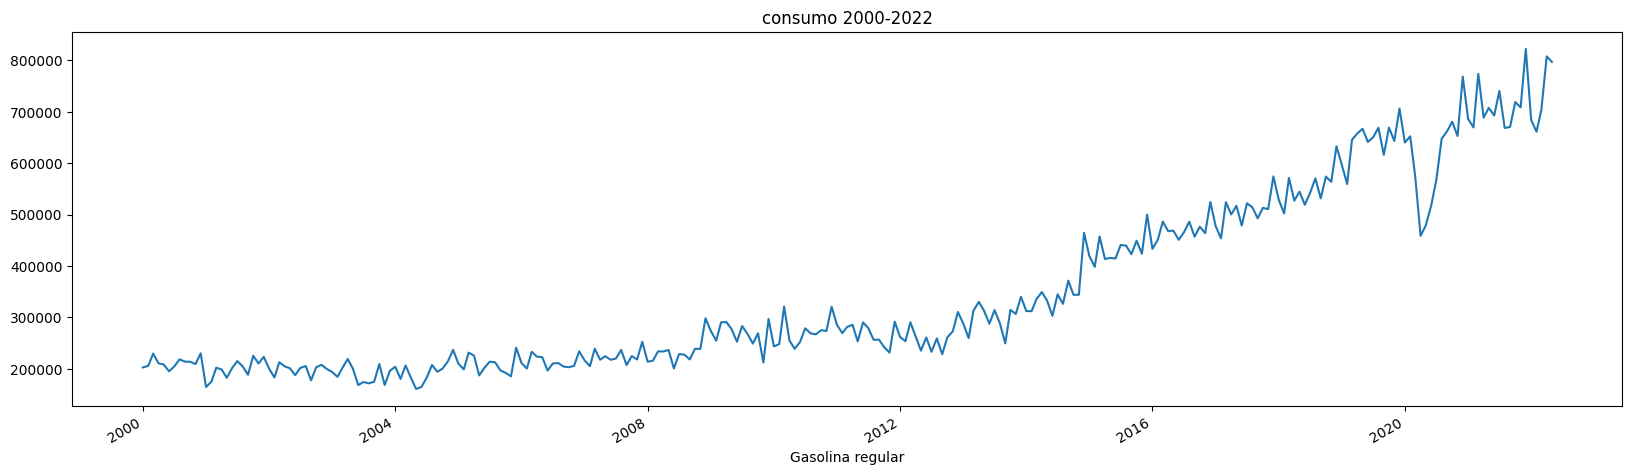

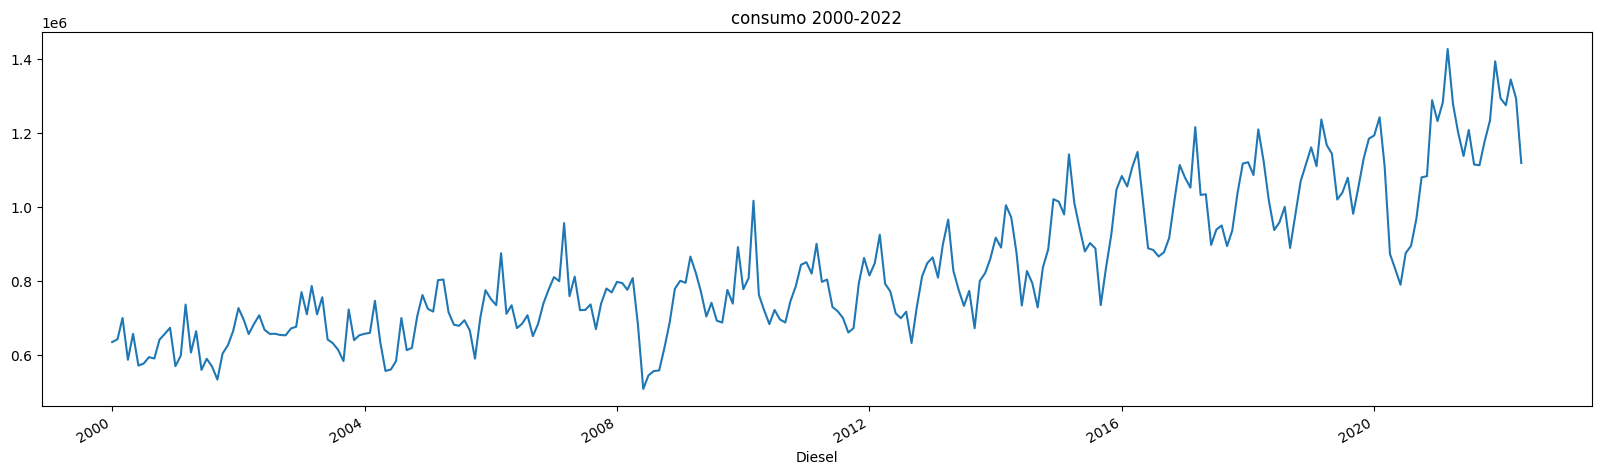

In [88]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = df['Fecha']
    y = df[gas]

    plt.title(dfToUse+" 2000-2022")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Por mes

In [89]:
dfPerMonth = df.groupby(df['Fecha'].dt.month)
dfPerMonth = dfPerMonth.sum()

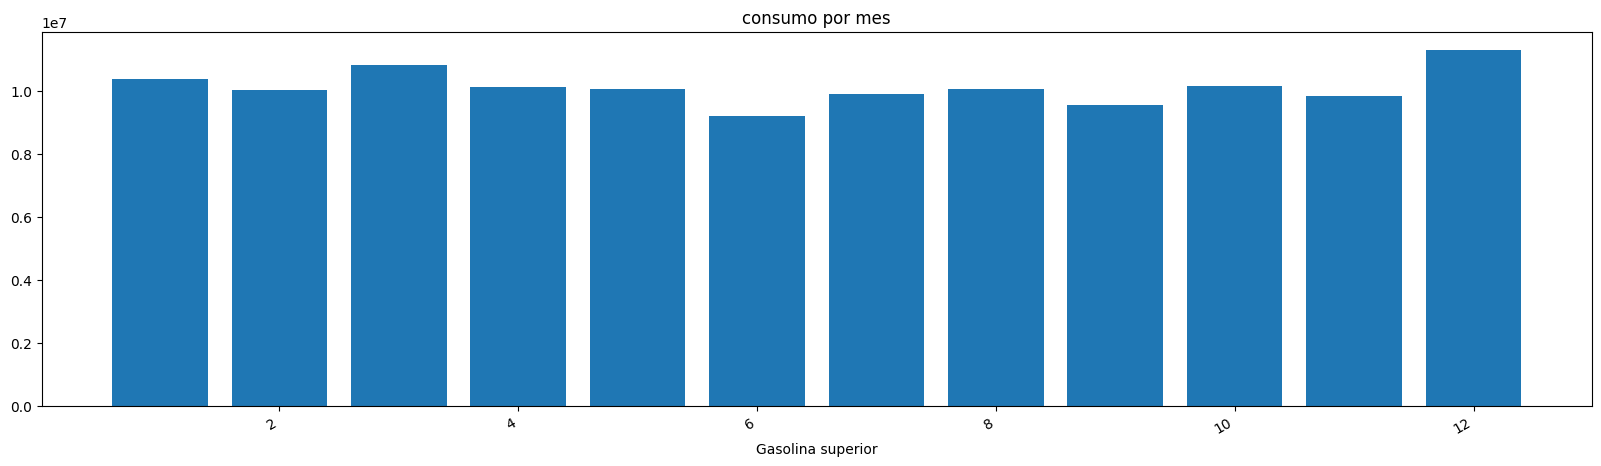

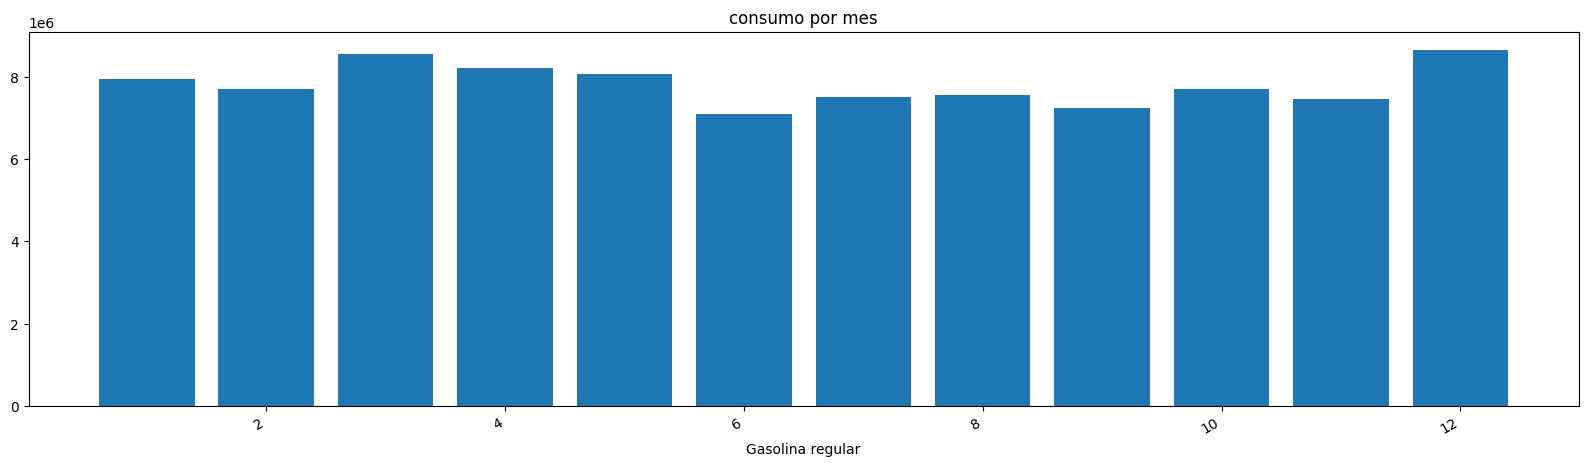

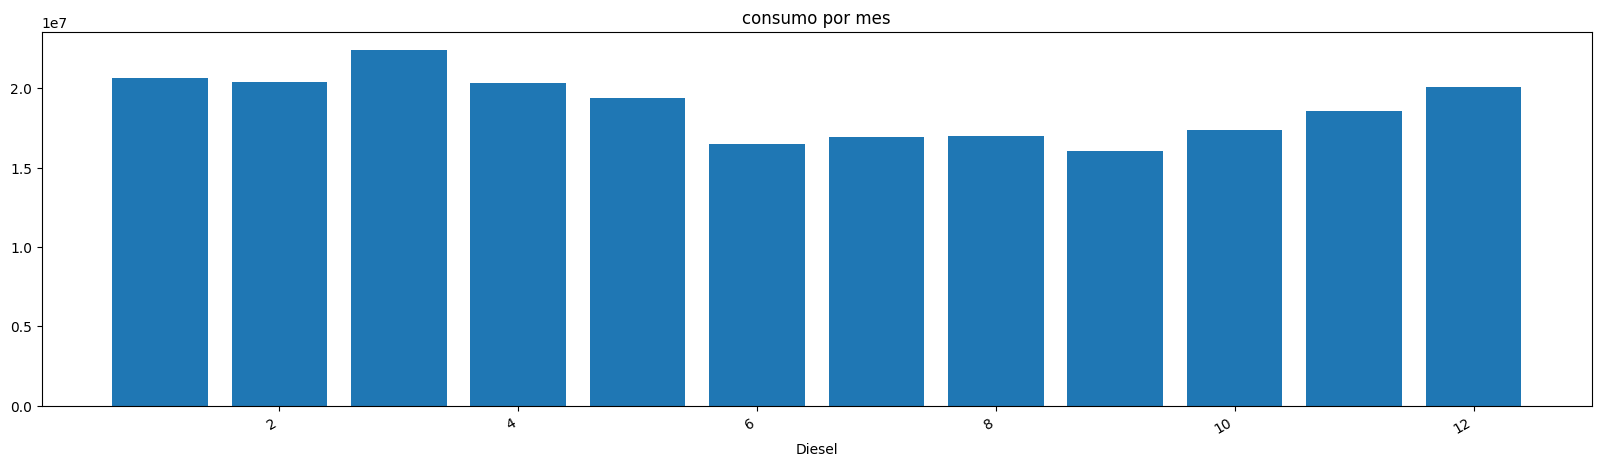

In [90]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = dfPerMonth.index
    y = dfPerMonth[gas]


    plt.title(dfToUse+" por mes")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.bar(x, y)
    plt.show()

# Comportamiento en la pandemia

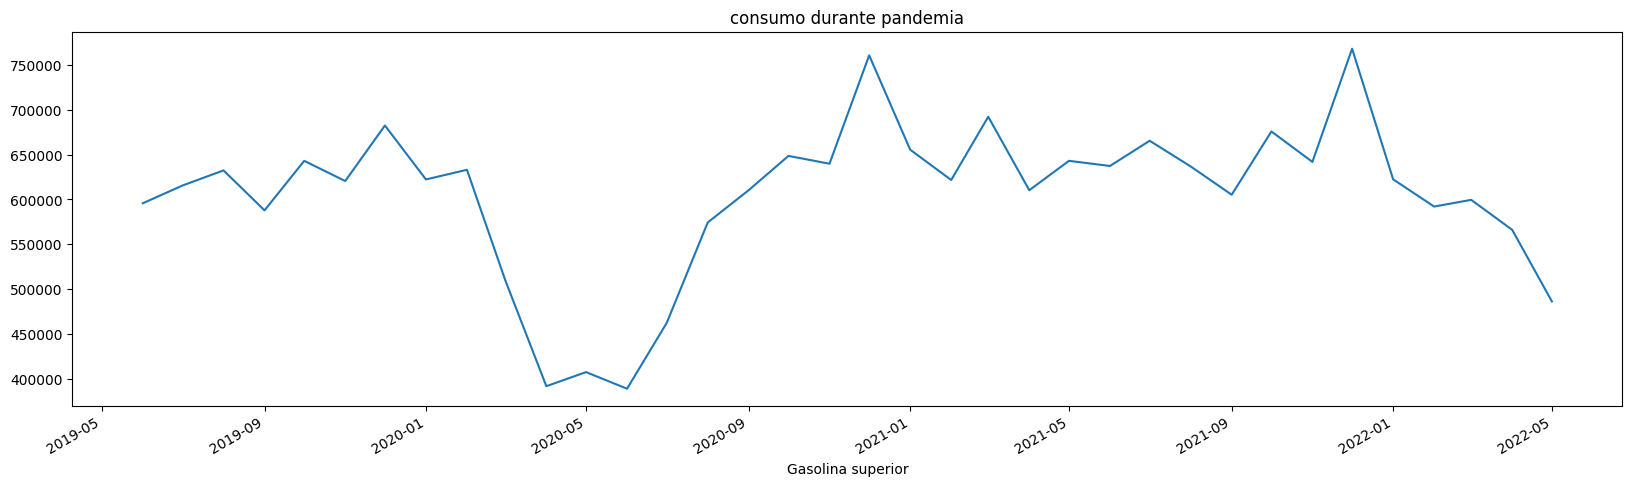

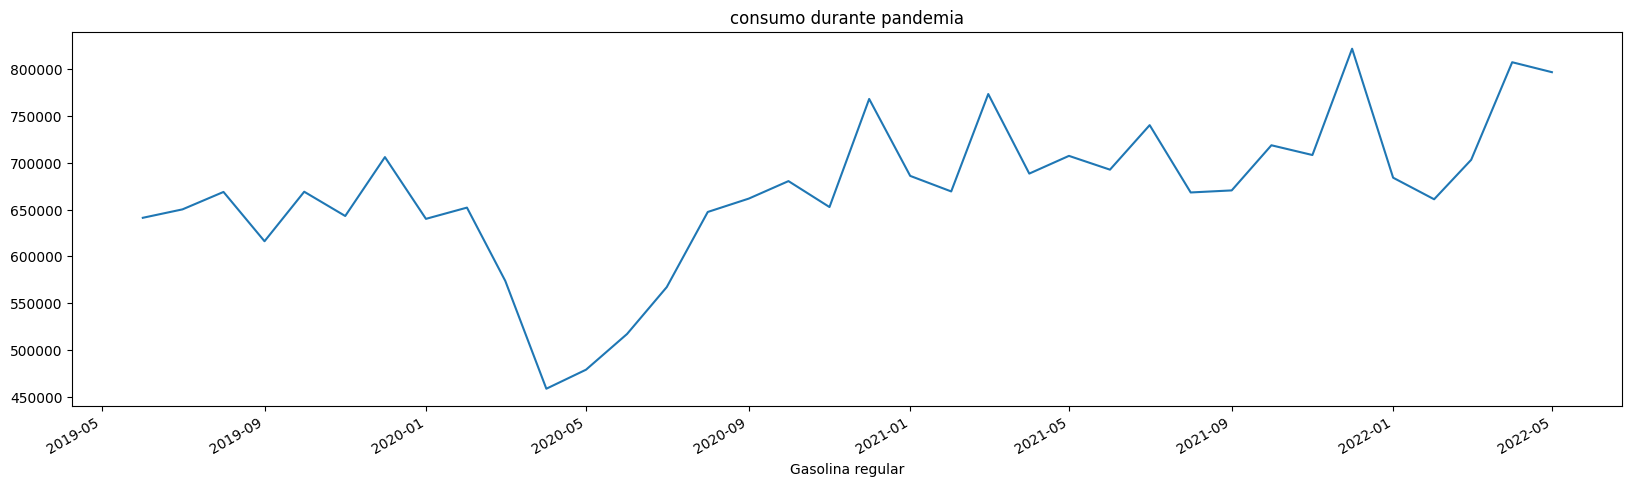

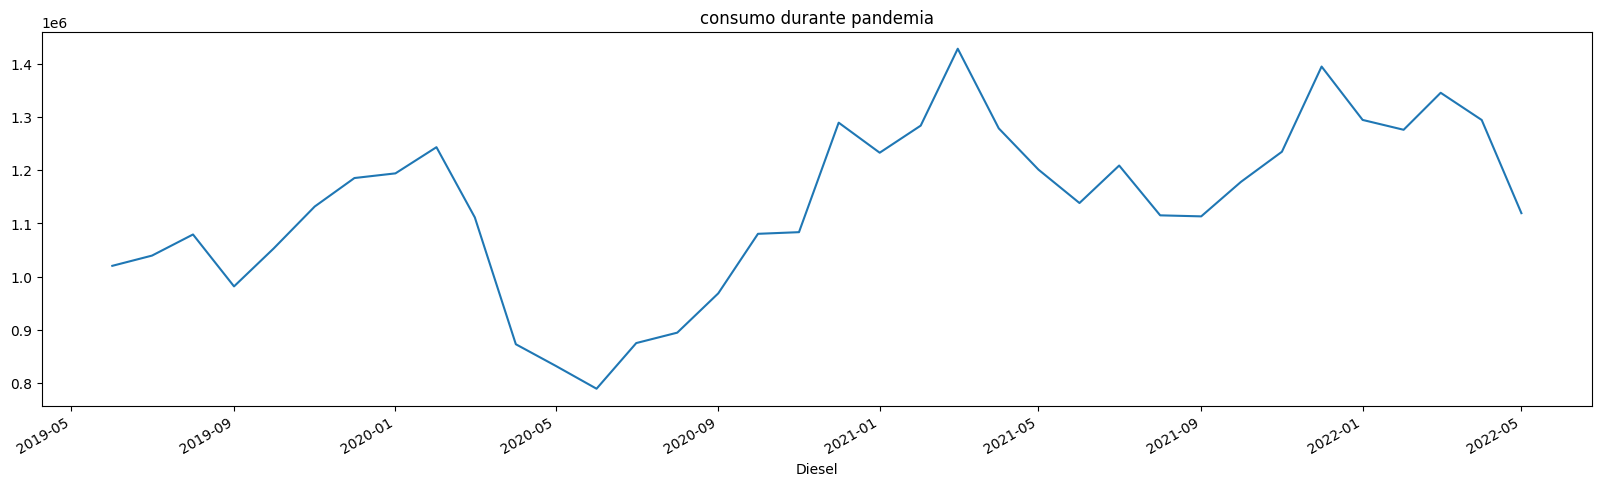

In [91]:
plt.rcParams["figure.figsize"] = (20,5.5)
quant_to_have = 12

for gas in quant_vars:
    x = df['Fecha'].tail(quant_to_have * 3)
    y = df[gas].tail(quant_to_have * 3)

    plt.title(dfToUse+" durante pandemia")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Separando test y train

In [92]:
rows = len(df)
train_df = df[0:rows-17]
test_df = df[rows-17:]
print(len(train_df), len(test_df))

252 17


## Pasos para construir modelos ARIMA
1. Identificación
2. Estimación
3. Validación
4. Predicción

In [93]:
def make_timeline(column):
  plt.rcParams["figure.figsize"] = (20,5.5)
  mediaGasoline = train_df[column].rolling(window=12).mean()
  deGasoline = train_df[column].rolling(window=12).std()

  original = plt.plot(train_df[column], color="blue", label="Original")
  media = plt.plot(mediaGasoline, color='red', label = 'Media ' + dfToUse)
  ds = plt.plot(deGasoline, color='black', label = 'Desviación Estándar ' + dfToUse)
  plt.legend(loc = 'best')
  plt.title('Media y desviación estándar ' + column)
  plt.show(block=False)

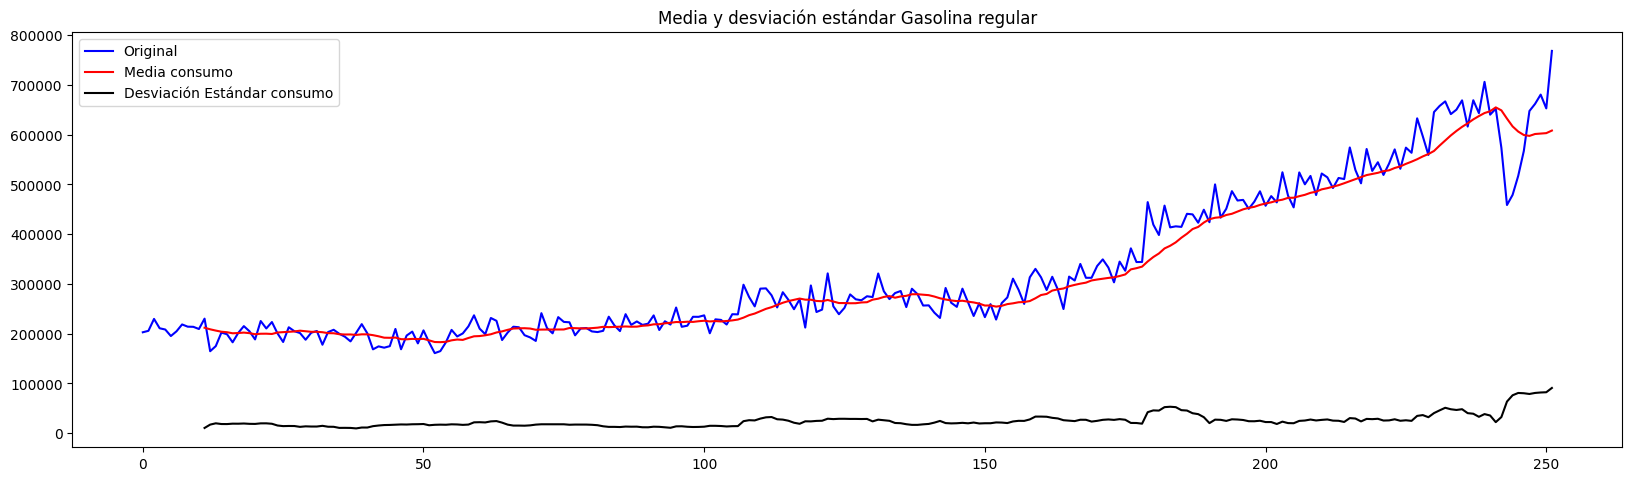

In [94]:
make_timeline('Gasolina regular')

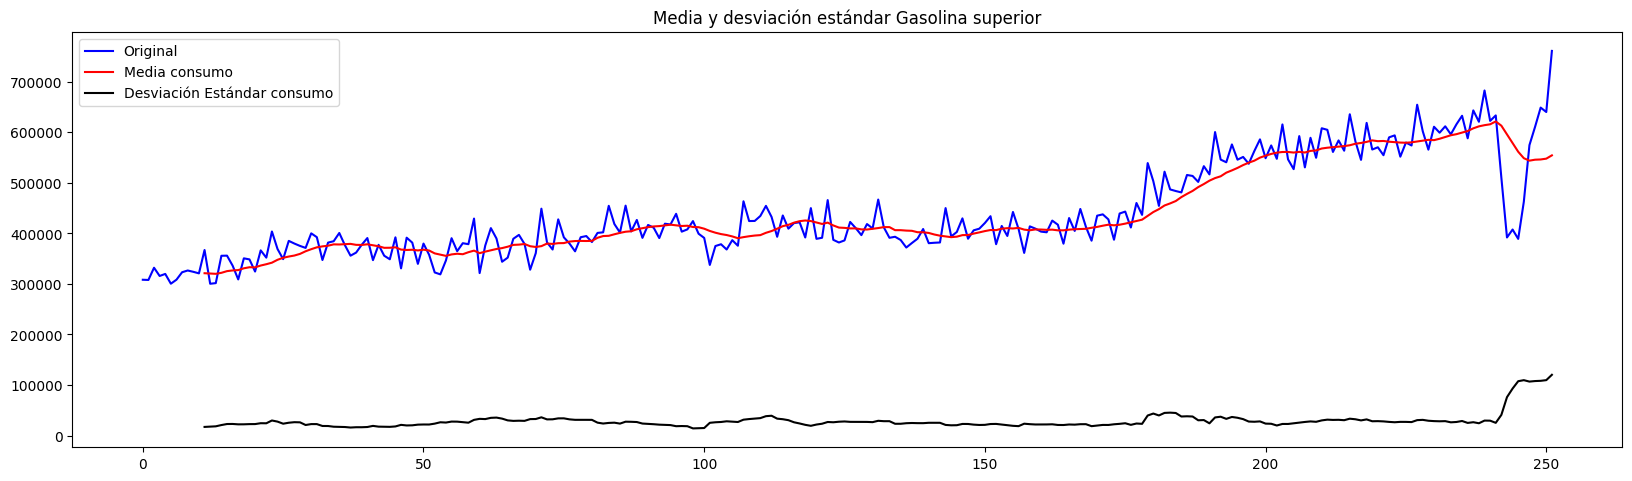

In [95]:
make_timeline('Gasolina superior')

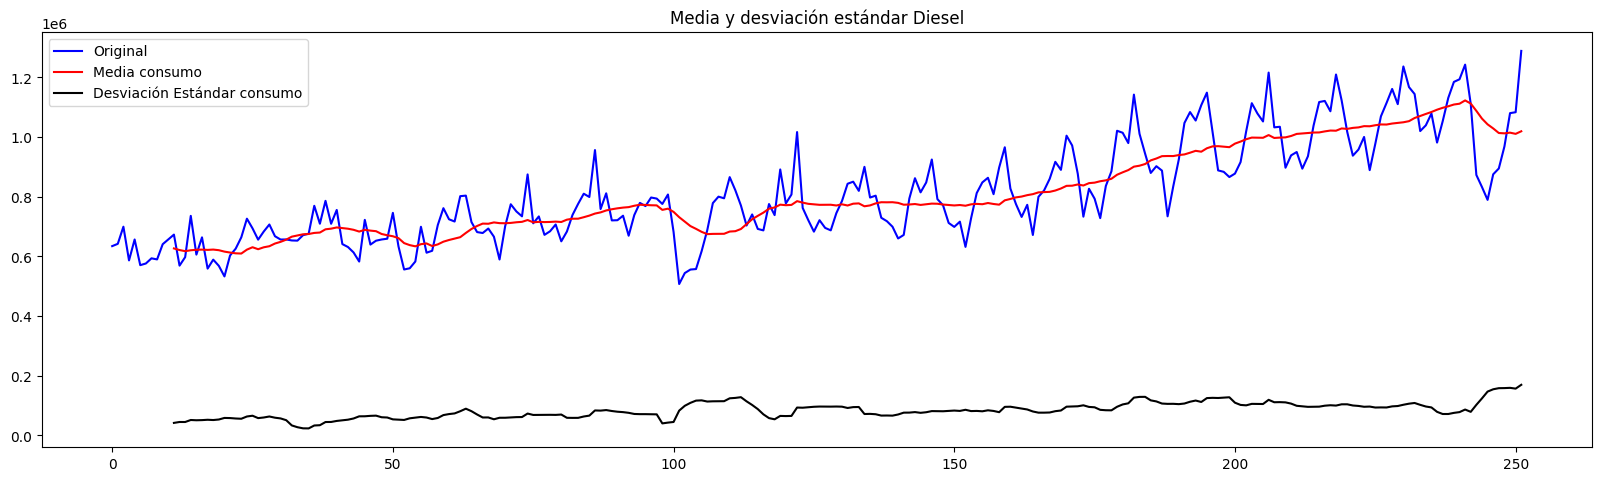

In [96]:
make_timeline('Diesel')

In [97]:
train_regular = train_df[['Fecha', 'Gasolina regular']]
train_superior = train_df[['Fecha', 'Gasolina superior']]
train_diesel = train_df[['Fecha', 'Diesel']]

test_regular = test_df[['Fecha', 'Gasolina regular']]
test_superior = test_df[['Fecha', 'Gasolina superior']]
test_diesel = test_df[['Fecha', 'Diesel']]

In [98]:
# Gasolina regular
train_regular['Gasolina regular'] = train_regular['Gasolina regular'].astype(float)
train_regular_indexed = train_regular.set_index(['Fecha'])
# Gasolina superior
train_superior['Gasolina superior'] = train_superior['Gasolina superior'].astype(float)
train_superior_indexed = train_superior.set_index(['Fecha'])
# Gasolina diesel
train_diesel['Diesel'] = train_diesel['Diesel'].astype(float)
train_diesel_indexed = train_diesel.set_index(['Fecha'])


######### TEST ###############
# Gasolina regular
test_regular['Gasolina regular'] = test_regular['Gasolina regular'].astype(float)
test_regular_indexed = test_regular.set_index(['Fecha'])
# Gasolina superior
test_superior['Gasolina superior'] = test_superior['Gasolina superior'].astype(float)
test_superior_indexed = test_superior.set_index(['Fecha'])
# Gasolina diesel
test_diesel['Diesel'] = test_diesel['Diesel'].astype(float)
test_iesel_indexed = test_diesel.set_index(['Fecha'])

In [99]:
train_regular_indexed

,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34
...,...
2020-08-01,647375.58
2020-09-01,661665.58
2020-10-01,680362.07


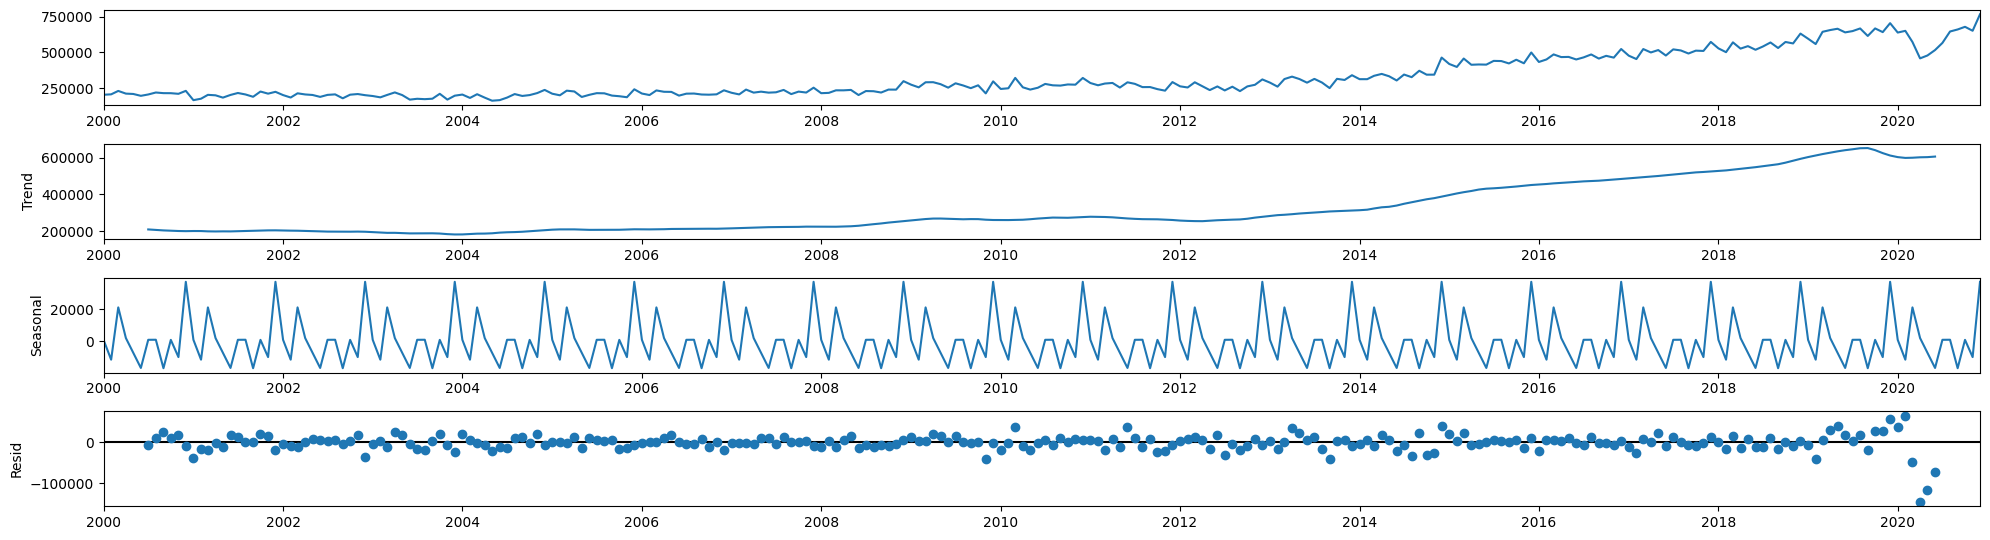

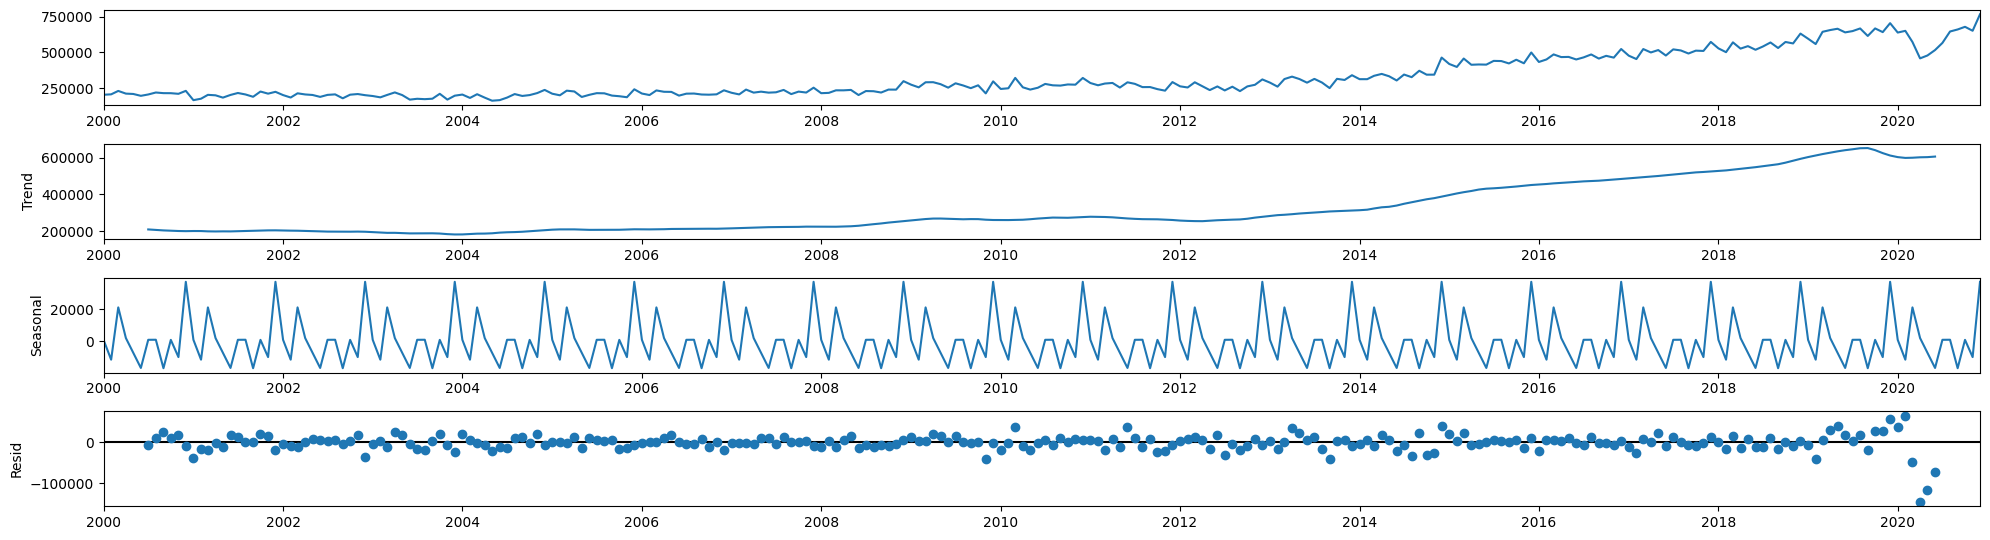

In [100]:
descomposicion = seasonal_decompose(train_regular_indexed)
descomposicion.plot()

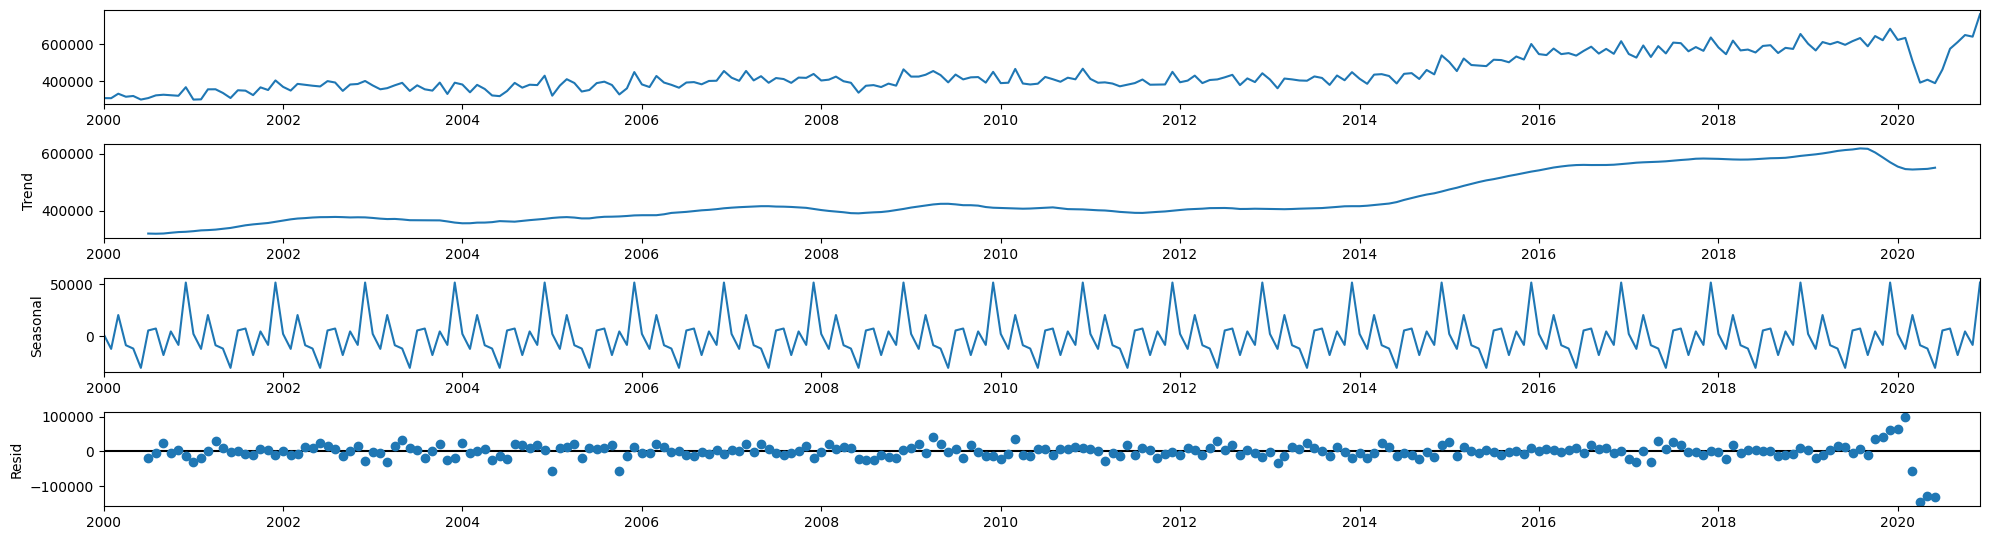

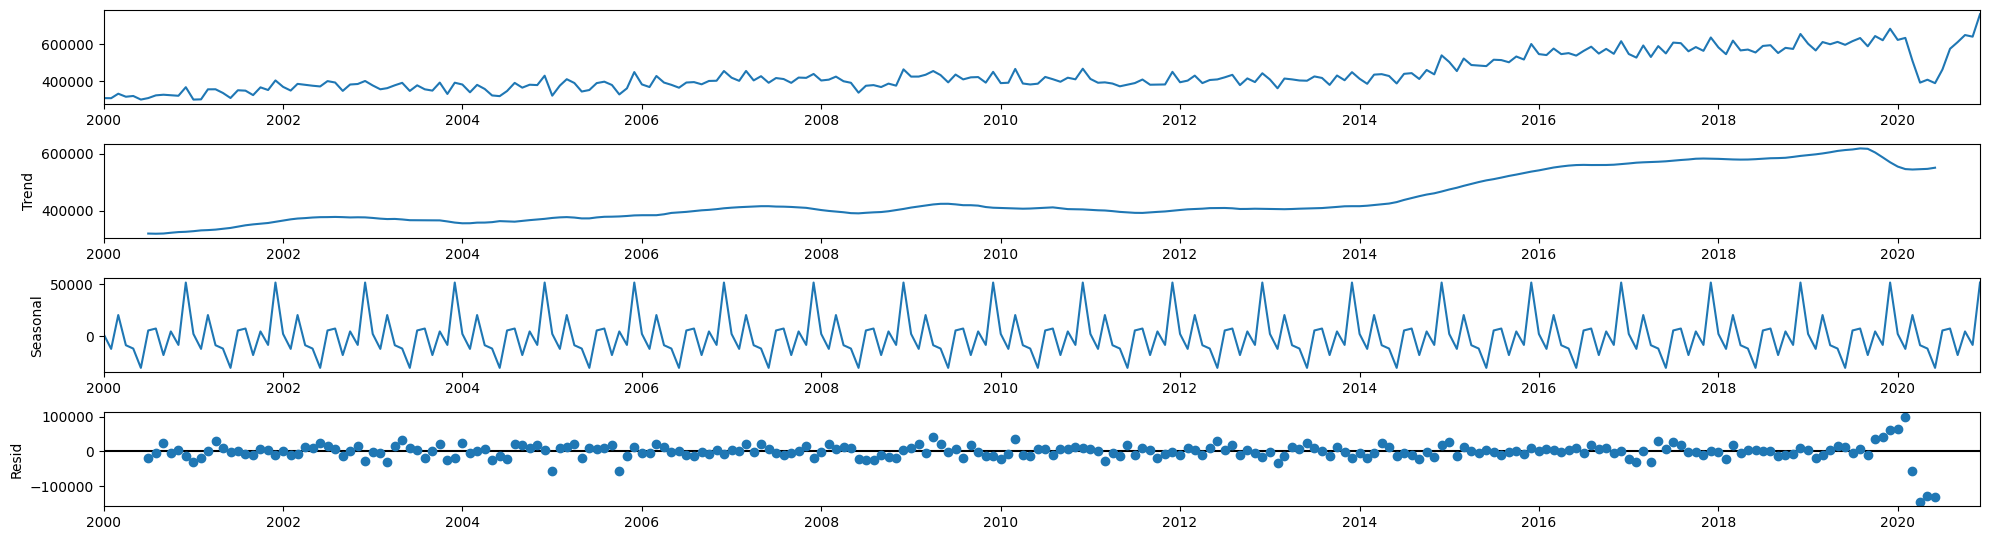

In [101]:
descomposicion = seasonal_decompose(train_superior_indexed)
descomposicion.plot()

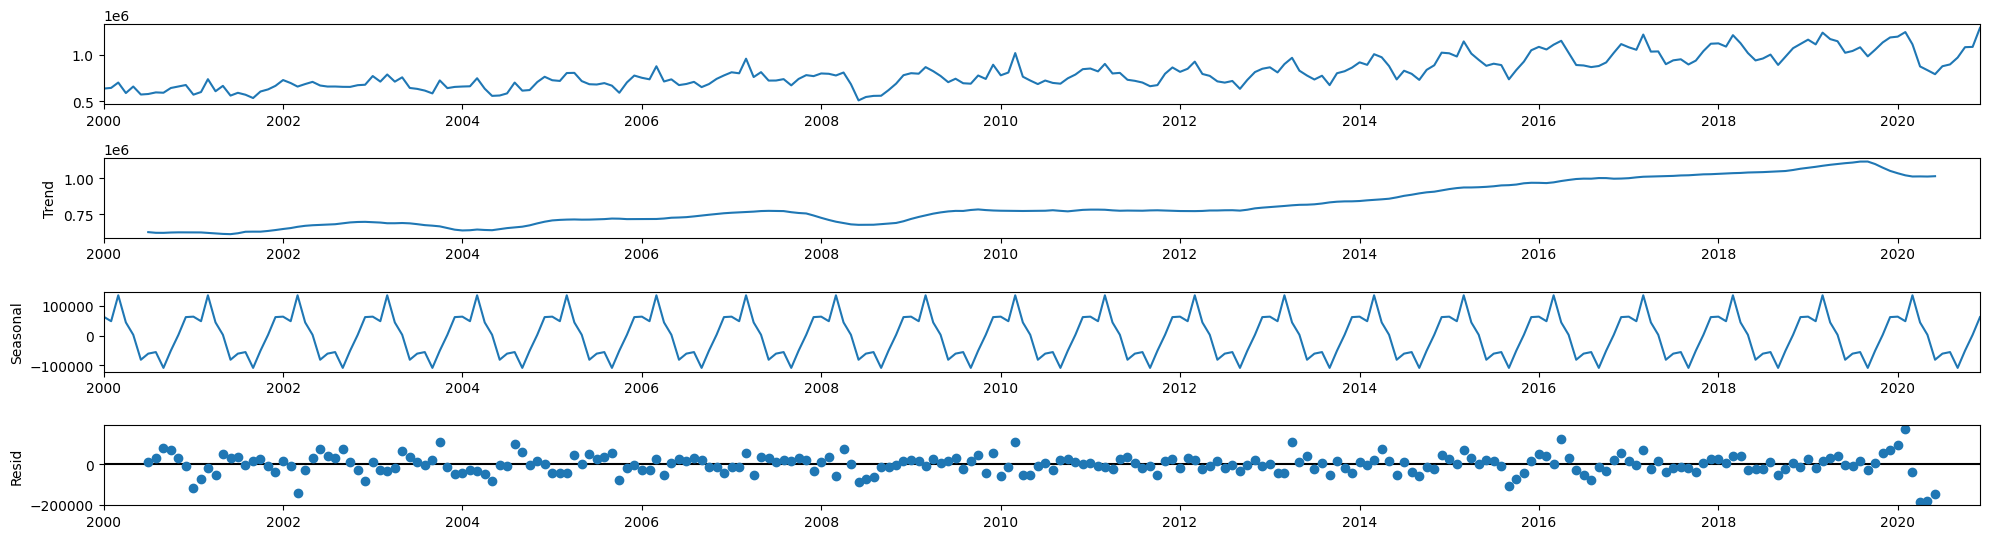

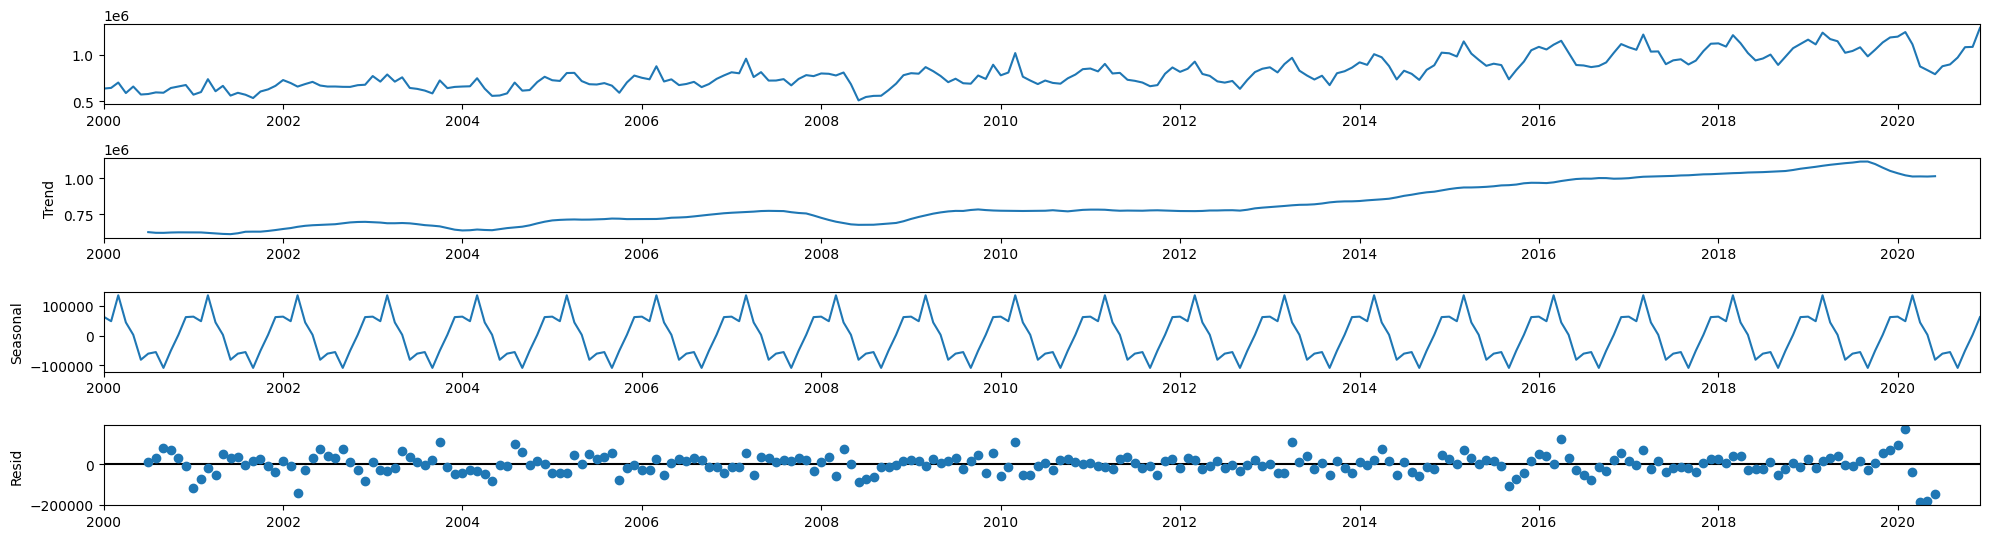

In [102]:
descomposicion = seasonal_decompose(train_diesel_indexed)
descomposicion.plot()

# Estimación

In [103]:
train_regular_indexed = train_regular_indexed[0:240]
train_superior_indexed = train_superior[0:240]
train_diesel_indexed = train_diesel[0:240]

In [104]:
train_regular_indexed

,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34
...,...
2019-08-01,668783.39
2019-09-01,616079.30
2019-10-01,669008.77


Estacionar en varianza

In [105]:
train_regular_gas = train_regular_indexed['Gasolina regular']

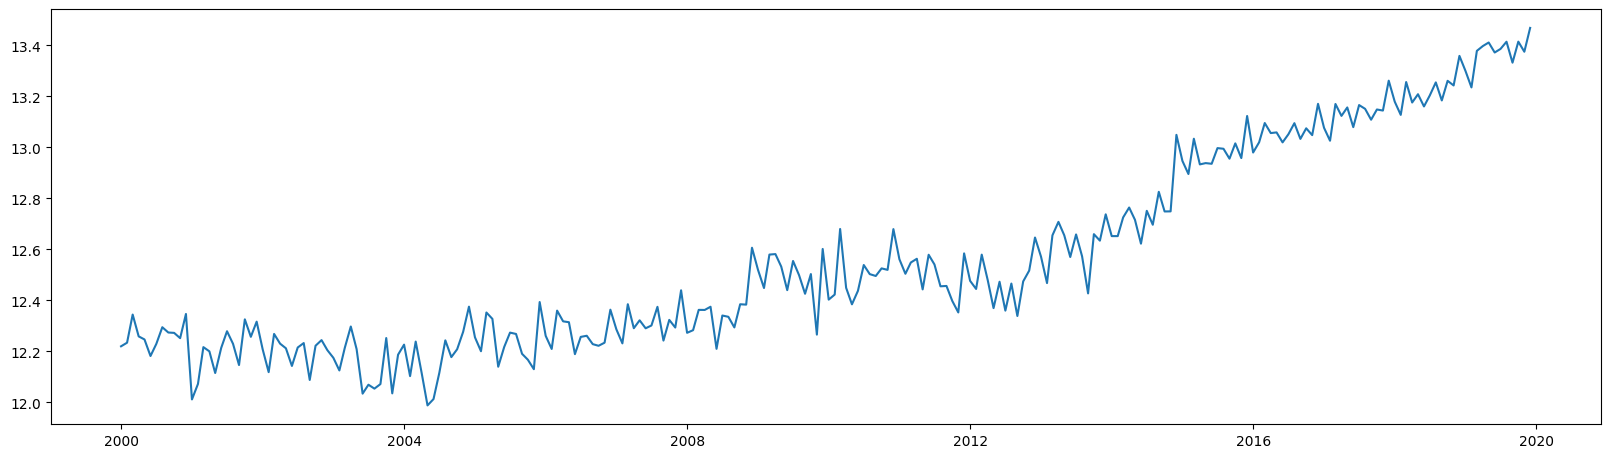

In [106]:
train_regular_log = np.log(train_regular_gas)
plt.plot(train_regular_log)

Con esta transformación pudimos estacionarizarla en varianza debido a que los picos se mantienen

In [107]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_regular_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          3.154508
p-value                        1.000000
# de retardos usados          12.000000
# de observaciones usadas    227.000000
Critical Value (1%)           -3.459490
Critical Value (5%)           -2.874358
Critical Value (10%)          -2.573602
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [108]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
train_regular_gas_log_diff = train_regular_gas.diff()
train_regular_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_regular_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.431888
p-value                        0.009919
# de retardos usados          12.000000
# de observaciones usadas    226.000000
Critical Value (1%)           -3.459620
Critical Value (5%)           -2.874415
Critical Value (10%)          -2.573632
dtype: float64


El p-value es menor a 0.05 por lo que se rechaza la hipótesis nula. La serie es estacionaria en media con un d=1

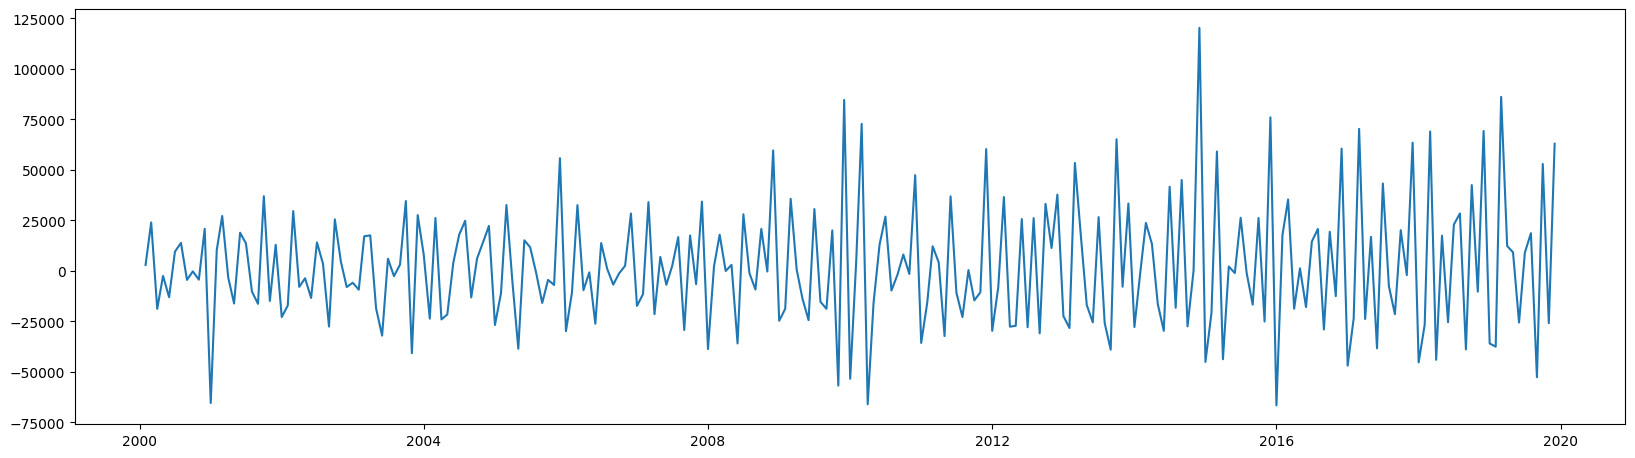

In [109]:
plt.plot(train_regular_gas_log_diff)

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [110]:
train_regular_gas_diff = train_regular_log.diff()
train_regular_gas_diff.dropna(inplace = True)
tsa_acf = acf(train_regular_gas_diff,nlags=5,fft=False)
tsa_pacf = pacf(train_regular_gas_diff, nlags=36)
tsa_acf

array([ 1.        , -0.43251711, -0.14227986,  0.14891018, -0.04858585,
        0.15916638])

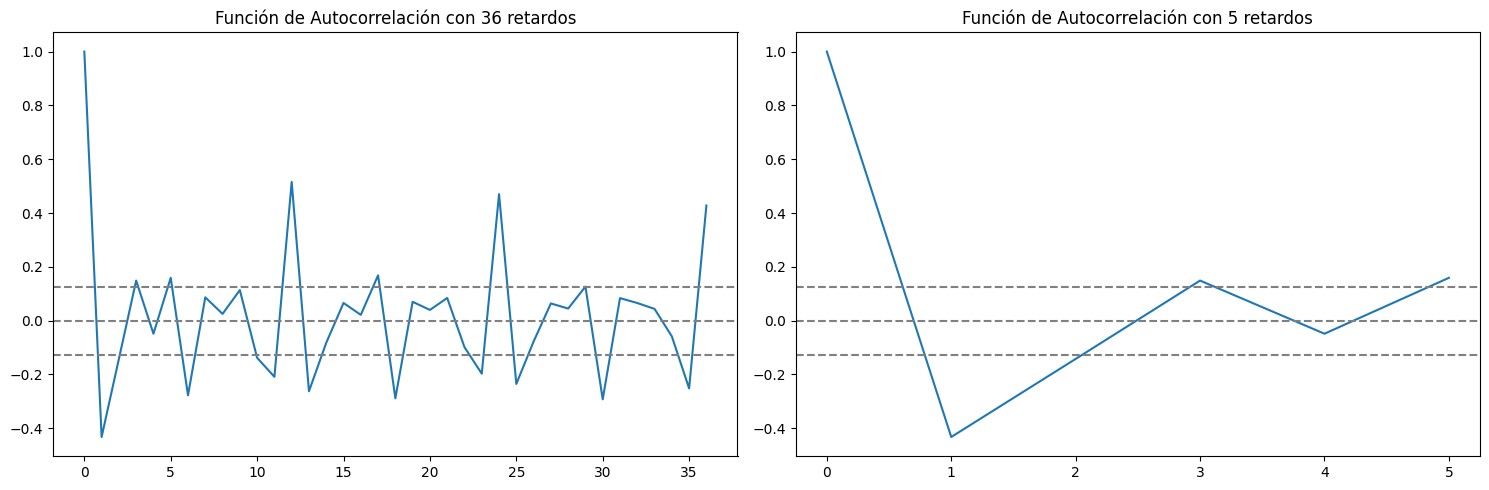

In [111]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(train_regular_gas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')

plt.subplot(122) 
plt.plot(acf(train_regular_gas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

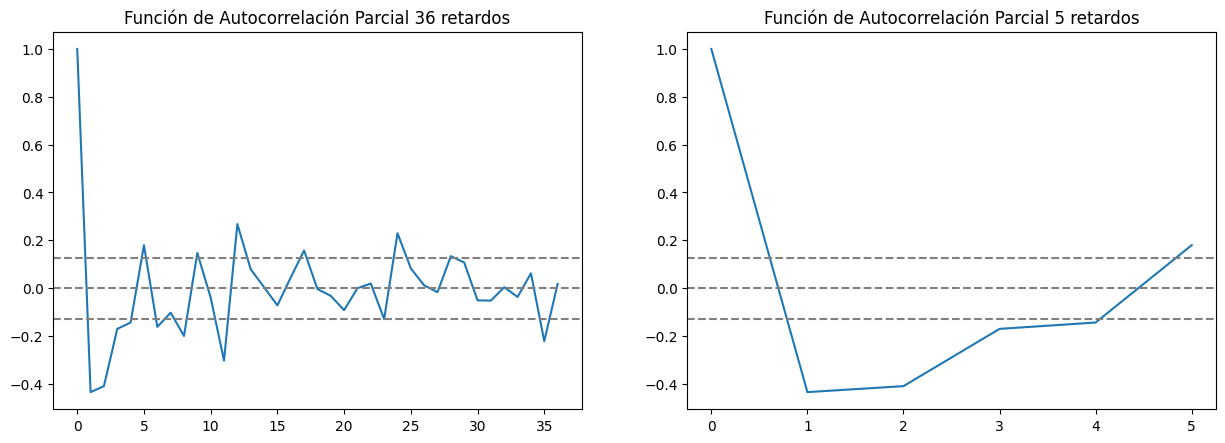

In [112]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(train_regular_gas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(train_regular_gas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionalidad

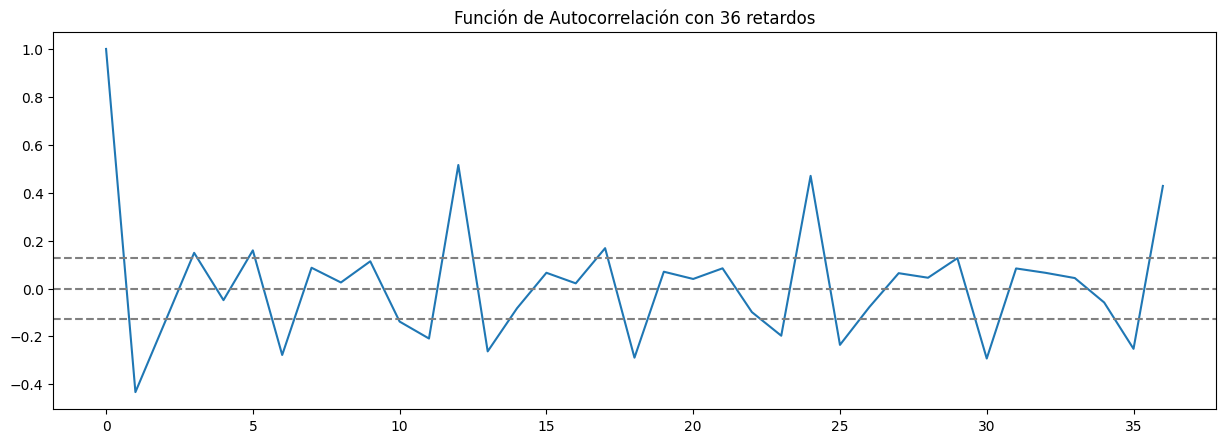

In [113]:
plt.plot(acf(train_regular_gas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar entre 3 - 12 y 15 - 24 (estacionalidad)

In [114]:
train_regular_log_diff = train_regular_log.diff(12)
train_regular_log_diff.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 8 retardos')

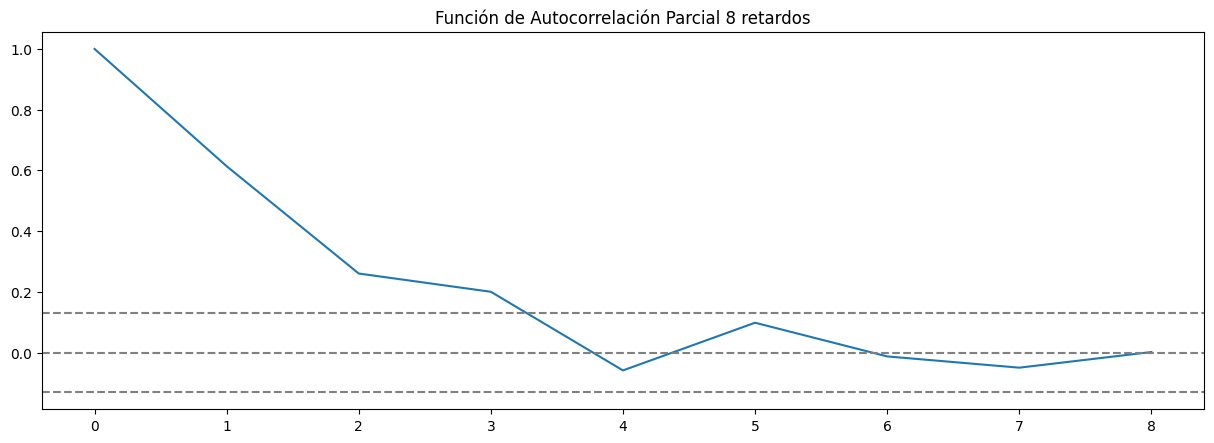

In [115]:

plt.plot(pacf(train_regular_log_diff, nlags=8))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 8 retardos')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 3
- D = 1
- Q = 0

### Analisis residuos

In [116]:
modelo121 = SARIMAX(train_regular_log, order=(1,2,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4416      0.062     -7.089      0.000      -0.564      -0.320
ma.L1         -1.0000    413.502     -0.002      0.998    -811.448     809.448
ar.S.L12      -0.7042      0.057    -12.461      0.000      -0.815      -0.593
ar.S.L24      -0.4608      0.078     -5.911      0.000      -0.614      -0.308
ar.S.L36      -0.2647      0.070     -3.799      0.000      -0.401      -0.128
sigma2         0.0047      1.928      0.002      0.998      -3.773       3.783


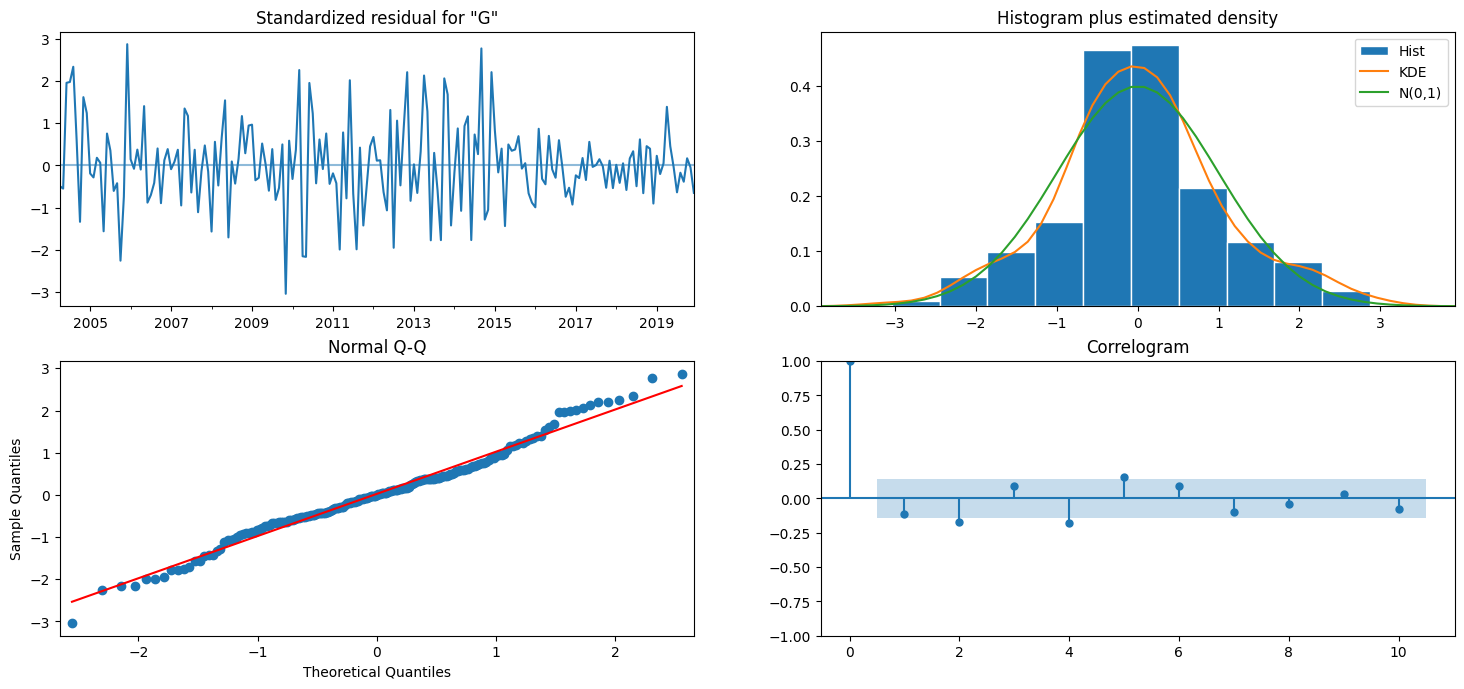

In [117]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [118]:
modelo221 = SARIMAX(train_regular_log, order=(2,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m221 = modelo221.fit()
print(resultado_m221.summary().tables[1])

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5231      0.067     -7.752      0.000      -0.655      -0.391
ar.L2         -0.2735      0.062     -4.393      0.000      -0.396      -0.151
ma.L1         -1.0000    243.355     -0.004      0.997    -477.968     475.968
ar.S.L12      -0.6206      0.065     -9.496      0.000      -0.749      -0.493
ar.S.L24      -0.2772      0.065     -4.264      0.000      -0.405      -0.150
sigma2         0.0051      1.249      0.004      0.997      -2.443       2.453


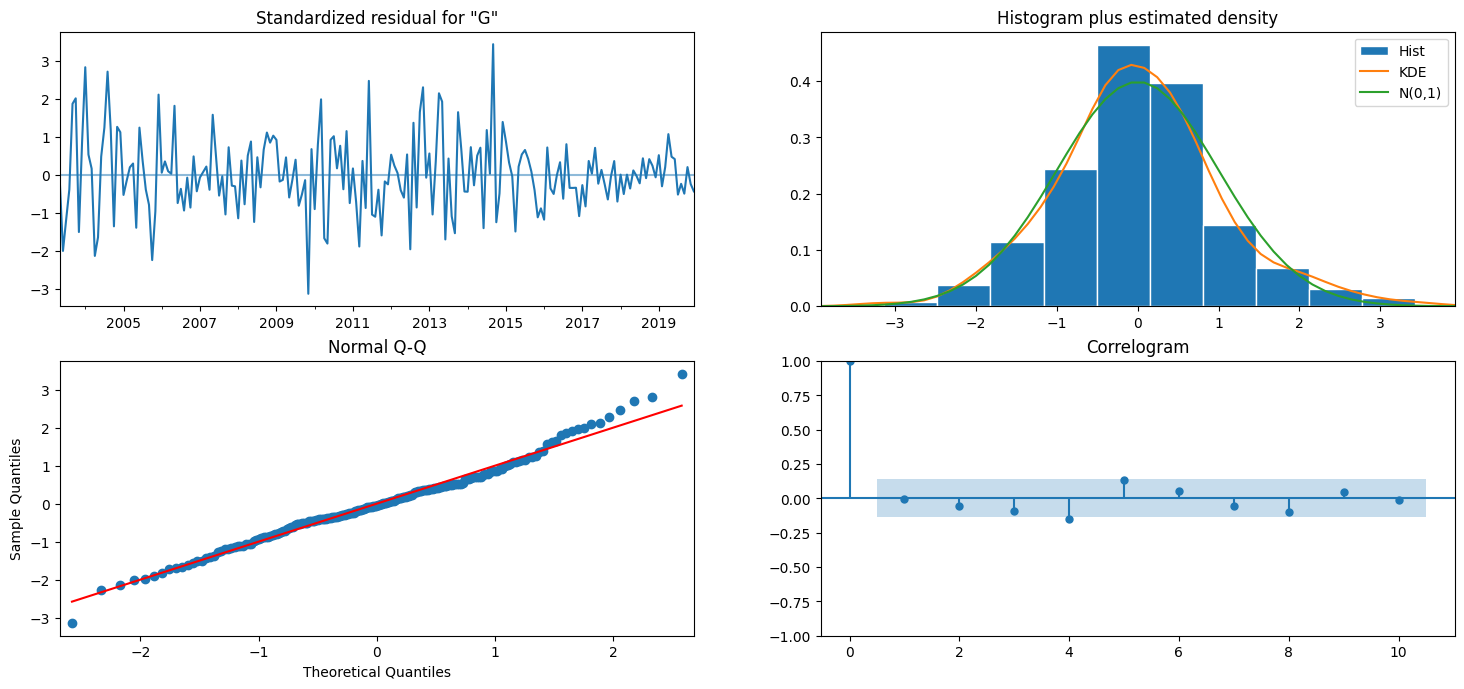

In [119]:
resultado_m221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [120]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_m121.aic)
print("Modelo 221=",resultado_m221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_m121.bic)
print("Modelo 221=",resultado_m221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -461.36481551613093
Modelo 221= -470.21960778667784
Resultados de BIC (Bayesian information criterion)
Modelo 121= -441.91433342577307
Modelo 221= -450.4297035873896


De acuerdo a ambos indicadores es mejor el modelo p=2, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Predicción con el mejor modelo

In [121]:
test_regular_indexed.index[0]

Timestamp('2021-01-01 00:00:00')

In [122]:
df_regular_indexed = df[['Fecha', 'Gasolina superior']]
df_regular_indexed =  df_regular_indexed.set_index(['Fecha'])
df_regular_indexed['2021-01-01':]

,Gasolina superior
Fecha,
2021-01-01,655513
2021-02-01,621712
2021-03-01,692240
2021-04-01,610311
2021-05-01,643077
2021-06-01,637333
2021-07-01,665473
2021-08-01,636825
2021-09-01,605258


In [123]:
test_regular_indexed.index[0]

Timestamp('2021-01-01 00:00:00')

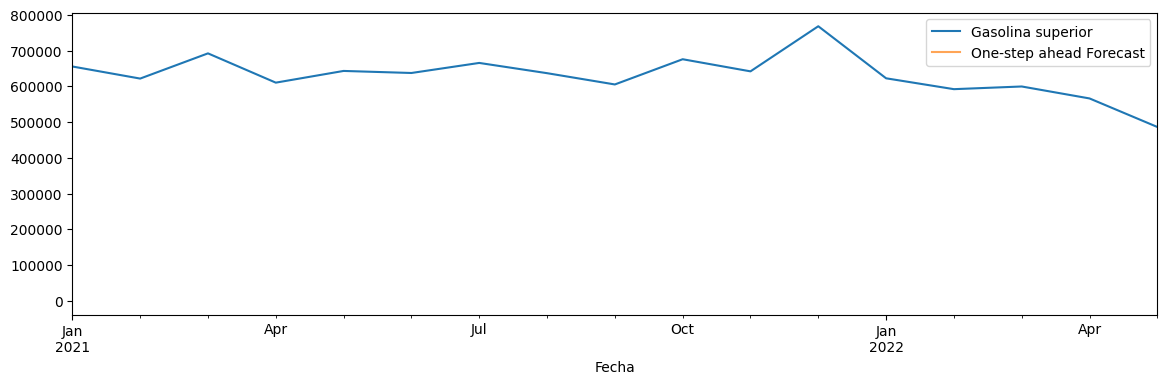

In [124]:
pred = resultado_m221.get_prediction(start=test_regular_indexed.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = df_regular_indexed['2021-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred